In [25]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

import os

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn import neighbors

In [9]:
# # load data
# ssize = 1000000
# df2013trip = pd.read_csv('raw_data/trip_data_1.csv', nrows=ssize)
# df2013fare = pd.read_csv('raw_data/trip_fare_1.csv', nrows=ssize)
# # merge DFs
# df2013fare.rename(columns={
#         ' hack_license' : 'hack_license',
#         ' vendor_id' : 'vendor_id',
#         ' pickup_datetime' : 'pickup_datetime',
#         ' payment_type' : 'payment_type',
#         ' fare_amount' : 'fare_amount',
#         ' surcharge' : 'surcharge',
#         ' mta_tax' : 'mta_tax',
#         ' tip_amount' : 'tip_amount',
#         ' tolls_amount' : 'tolls_amount',
#         ' total_amount' : 'total_amount'
#     }, inplace=True)
# merged2013df = pd.merge(df2013trip, df2013fare, on=['medallion', 'hack_license', 'vendor_id', 'pickup_datetime'], how='inner')
# # filter bad points
# merged2013df = merged2013df[merged2013df.pickup_latitude != 0]
# merged2013df = merged2013df[merged2013df.pickup_longitude != 0]
# merged2013df = merged2013df[merged2013df.dropoff_latitude != 0]
# merged2013df = merged2013df[merged2013df.dropoff_longitude != 0]
# merged2013df = merged2013df.reset_index(drop=True)
# # tip amount as % of fare
# merged2013df['tip_amount_normalized'] = merged2013df.tip_amount/(merged2013df.total_amount - merged2013df.tip_amount)
# # filter odd payment methods
# merged2013df = merged2013df[merged2013df.payment_type != 'UNK']
# merged2013df = merged2013df[merged2013df.payment_type != 'DIS']
# merged2013df = merged2013df[merged2013df.payment_type != 'NOC']
# merged2013df = merged2013df.reset_index(drop=True)
# # Create payment index (CARD = 1, CASH = 0)
# payment_types = list(merged2013df.payment_type.unique())
# payment_dict = dict(zip(payment_types, map(lambda x: payment_types.index(x), payment_types)))
# merged2013df['payment_idx'] = merged2013df.payment_type.apply(lambda x: payment_dict[x])
# payment_dict

# #convert pickup and dropoff to date objects
# merged2013df['pickup_datetime'] = pd.to_datetime(merged2013df['pickup_datetime'])
# merged2013df['dropoff_datetime'] = pd.to_datetime(merged2013df['dropoff_datetime'])
# def seconds_since_midnight(d):
#     ddelta = (d - d.replace(hour=0, minute=0, second=0, microsecond=0))
#     return ddelta.total_seconds()
# merged2013df['secs_since_midnight'] = merged2013df.pickup_datetime.apply(seconds_since_midnight)

# Assigning classes
# def tip_to_class(n):
#     if n < 0.05:
#         return 1
#     if n < 0.1:
#         return 2
#     if n < 0.15:
#         return 3
#     if n < 0.2:
#         return 4
#     if n < 0.25:
#         return 5
#     if n < 0.3:
#         return 6
#     return 7

# merged2013df['tip_class'] = merged2013df.tip_amount_normalized.apply(tip_to_class)
# card_df = merged2013df[merged2013df.payment_idx == 1]
# merged2013df.to_csv('merged2013df.csv')
# card_df.to_csv('card_df.csv')

In [10]:
merged2013df = pd.read_csv('merged2013df.csv')
card_df = pd.read_csv('card_df.csv')

Before we dive into how location affects tips, let's make sure that cabbies are all relatively alike, that was geographic distribution of cabbies doesn't affect our classification (i.e. an exception cabbie who gets 30% tips all the time lives in one neighborhood and only drives there doesn't affect our data). We'll plot histograms of the average tip percentage for each cabbie, and overall, and see how they match up

In [11]:
classes_as_bins = [0, .05, 0.1, .15, .20, .25, .30]

tip_df = card_df[['medallion', 'tip_amount_normalized']]
tip_amounts = tip_df.groupby('medallion').mean().tip_amount_normalized.values
# truncate out the huge values just for visualization
tip_amounts = tip_amounts[tip_amounts < 0.4]

# from http://stackoverflow.com/questions/5498008/pylab-histdata-normed-1-normalization-seems-to-work-incorrect
# because normed=True is based on the PDF, not the PMF. Because here we want to see the percent of cabbies
# in each bucket, we'll manually norm
def plot_normed_to_one(values):
    weights = np.ones_like(values)/float(len(values))
    plt.hist(values, weights=weights, bins=classes_as_bins)

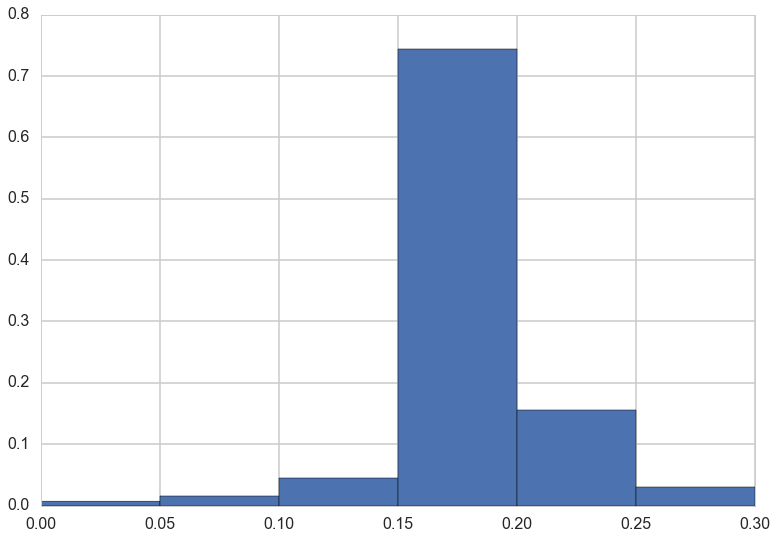

In [12]:
plot_normed_to_one(tip_amounts)

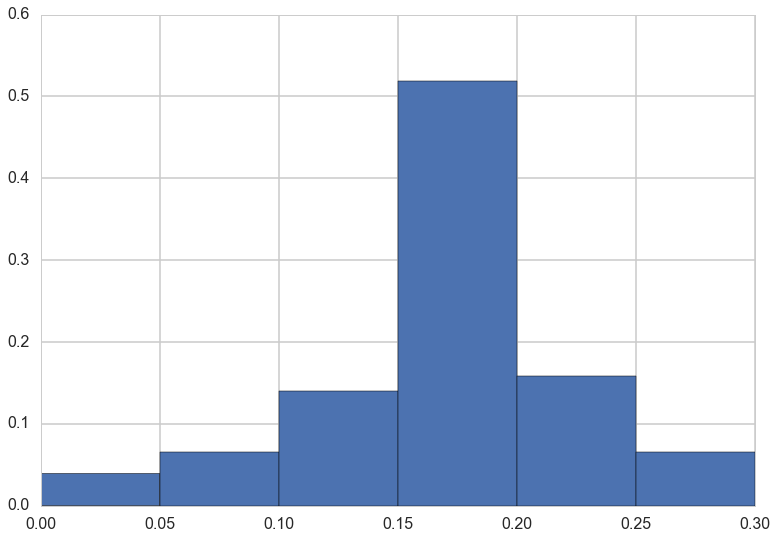

In [13]:
plot_normed_to_one(card_df.tip_amount_normalized.values)

It looks like just under 80% of cabbies get a tip in the range [15,20), and just about 50% of all tips are in that range. This tells us most cabbies are alike, and that our simplest classifier (just guess that a tip will be in that range, can only be slightly better than 50% accurate. Let's see if we can beat that with kNN using the location of the pickup.

We'll use pickup location, since a driver can control where they pick up a passenger, and not so much where they drop them off. If we want to provide some service for drivers, we could tell them in which areas they typically pick up higher tipping customers.

# Part 5?: kNN for Tipping Zones

In [14]:
from sklearn.cross_validation import train_test_split

train_df, test_df = train_test_split(card_df, test_size=0.2)

train_X = train_df[['pickup_latitude', 'pickup_longitude']]
train_y = train_df.tip_class

test_X = test_df[['pickup_latitude', 'pickup_longitude']]
test_y = test_df.tip_class

In [2]:
# let's test out various values of n_neighbors and both different weigh_mechanisms:
n_neighbors = [10,50,100,200,500,1000]
weights = ['uniform', 'distance']

scores = {}
for weight in weights:
    for n in n_neighbors:
        clf = neighbors.KNeighborsClassifier(n, weights=weight)
        clf.fit(train_X,train_y)
        scores[(weight, n)] = (clf, clf.score(test_X, test_y))
        
best_clf = None
best_score = -float('inf')
for clf,score in scores.values():
    if score > best_score:
        best_clf = clf
        best_score = score

NameError: name 'neighbors' is not defined

In [16]:
best_score

0.52004451165577648

So, our best classifier on tip ranges can only get it right about 52% of the time, which is about the same as guessing it'll always be in the range [15%,20%). Surprisingly, the distance weights didn't change much. We were expecting distance weights to get a much better classification, since the data set is so skewed towards that one class, but it didn't get us a much better rating.

In [54]:
n_plot = 100

lats = card_df.pickup_latitude.values
longs = card_df.pickup_longitude.values
tips = card_df.tip_class.values

coordinates_by_classes = {}

for i in [1,2,3,4,5,6,7]:
    indices = np.where(tips==i)
    coordinates_by_classes[i] = (lats[indices[0]], longs[indices[0]])

{1: (array([ 40.756481,  40.72398 ,  40.689205, ...,  40.645096,  40.756905,
        40.719208]), array([-73.967133, -73.987923, -73.981209, ..., -73.780983, -73.97287 ,
       -74.00518 ])), 2: (array([ 40.757877,  40.719017,  40.795914, ...,  40.655949,  40.720867,
        40.780659]), array([-73.960197, -73.989433, -73.9729  , ..., -73.791489, -74.006317,
       -73.981255])), 3: (array([ 40.720055,  40.756634,  40.747166, ...,  40.743717,  40.773968,
        40.707645]), array([-73.996933, -73.997772, -73.98642 , ..., -73.998665, -73.872856,
       -74.00975 ])), 4: (array([ 40.720982,  40.756741,  40.740772, ...,  40.772366,  40.755207,
        40.779865]), array([-73.997292, -73.966843, -74.005455, ..., -73.978867, -73.965111,
       -73.950256])), 5: (array([ 40.730068,  40.729927,  40.674507, ...,  40.710922,  40.75098 ,
        40.744923]), array([-74.000313, -74.010414, -73.986771, ..., -73.960304, -73.976151,
       -73.991364])), 6: (array([ 40.760571,  40.756451,  40.75631

In [105]:
# http://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
plasma = cm = plt.get_cmap('plasma') 
cNorm  = colors.Normalize(vmin=min(tips), vmax=max(tips))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)

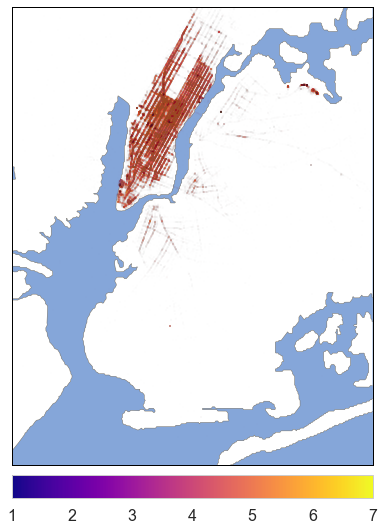

CPU times: user 3min 43s, sys: 3.46 s, total: 3min 46s
Wall time: 3min 49s


In [106]:
%%time
m = Basemap(projection='merc',llcrnrlat=40.55,urcrnrlat=40.82,\
            llcrnrlon=-74.1, urcrnrlon=-73.82, lat_ts=40.5,resolution='f')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white', lake_color='#85A6D9')


for i in [1,2,3,4,5,6,7]:
    m.scatter(coordinates_by_classes[i][1], coordinates_by_classes[i][0],\
              color=scalarMap.to_rgba(i), latlon=True, alpha=0.006, s=1,\
              zorder=10, cmap=plasma)
scalarMap._A = []
m.colorbar(mappable=scalarMap, location='bottom', ticks=[1,2,3,4,5,6,7])
plt.show()

As we can see from this plot of the tip classes, it's almost entirely impossible to distinguish any difference in tipping by region, corroborating the kNN analysis.